In [1]:
import numpy as np
import matplotlib.pyplot as plt

from simAnnealing import ciudades
from IPython.display import clear_output

from tsp import metodo_vecino_cercano

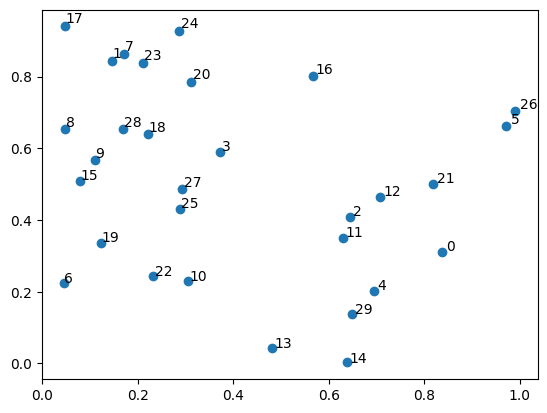

In [2]:
N = 30
X = ciudades(N)
plt.plot(X[:,0], X[:,1], 'o')
for i in range(N):
    plt.text(X[i,0]*1.01, X[i,1]*1.01, i)
plt.show()


In [3]:
class GeneticAlgorithm():
    def __init__(self, ciudades, poblationSize=100, mutationRate=0.05, generations=10, elitism=True, elitePercentage=0.01, tournamentSize=5):
        self.ciudades = ciudades
        self.N = len(ciudades)
        self.route = list(np.arange(self.N))+[0]

        self.poblationSize = poblationSize
        self.mutationRate = mutationRate
        self.generations = generations
        self.elitism = elitism
        self.elitePercentage = elitePercentage
        self.tournamentSize = tournamentSize
        
        self.distanceMatrix = self.dist_matrix() 
        self.distanciaTotal = self.totalDistance(range(self.N))

        self.poblation = np.random.permutation([[0]+list(np.random.permutation(range(1,self.N)))+[0] for _ in range(self.poblationSize)])
        self.fitness = np.array([self.getFitness(i) for i in self.poblation])
        self.bestRoute = self.poblation[np.argmax(self.fitness)]

        self.distances = []
    def dist_matrix(self):
        '''
        Función para calcular la matriz de distancias
        '''
        d = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                d[i][j] = np.linalg.norm(self.ciudades[i]-self.ciudades[j])
        return d
    
    def totalDistance(self, route):
        '''
        Función para calcular la distancia total de una ruta.
        '''
        return np.sum(self.distanceMatrix[route,np.roll(route,-1)])
    
    def getFitness(self, individuo):
        return self.totalDistance(individuo)**-1
    
    def mutation(self, indiviudo):
        '''
        Función para mutar un individuo
        '''
        new_route = indiviudo.copy()

        method = np.random.choice(['swap','inverse'])

        i,j = np.random.randint(1,self.N,2)
        while j==i:
            j = np.random.randint(1,self.N)


        if method == 'swap':
            new_route[i],new_route[j] = new_route[j],new_route[i]
        # Generamos la nueva ruta con un inverse aleatorio:
        if method == 'inverse':
            if i>j:
                i,j = j,i
            new_route[i:j+1] = new_route[i:j+1][::-1]
        
        if method == 'swap':
            if i>j:
                i,j = j,i
            new_route[i:j+1] = new_route[i:j+1][::-1]

        return new_route

    def plotRoute(self):
        '''
        Función para mostrar la ruta
        '''

        plt.figure(figsize=(10,10))
        plt.subplot(2,2,1)
        plt.plot(self.ciudades[self.route,0],self.ciudades[self.route,1],'o-')
        plt.title(f'Distancia total = {self.distanciaTotal:.2f}')
        plt.xlabel('x')
        plt.ylabel('y')
        for i in range(self.N):
            plt.text(self.ciudades[i][0]*1.01, self.ciudades[i][1], i, fontsize=10)
        
        plt.subplot(2,2,2)
        plt.plot(self.distances)
        plt.title('Distancia total')
        plt.xlabel('Generación')
        plt.ylabel('Distancia total')
        

        plt.subplot(2,2,3)
        plt.hist(self.fitness, bins=20)
        plt.title('Fitness')
        plt.show()
    def getElite(self):
        '''
        Función para obtener la elite de la población
        '''
        n = int(self.poblationSize*self.elitePercentage)
        return self.poblation[np.argsort(self.fitness)[-n:]]

    def tournamentSelection(self):
        '''
        Función para seleccionar un individuo mediante torneo
        '''
        selection = np.random.choice(self.poblationSize, self.tournamentSize, replace=False, p=self.fitness/self.fitness.sum())
        return selection[np.argmax(self.fitness[selection])]
    
    def crossover(self, parent1, parent2):
        '''
        Función para cruzar dos individuos
        '''
        child = parent1.copy()
        inx = [0,0]
        while inx[0] == inx[1]:
            inx = np.random.randint(1,self.N-1,2)
        inx.sort()
        i, j = inx   
        chromosomeP1 = parent1[i:j]
        
        chromosomeP2 = [i for i in parent2 if i not in chromosomeP1]
        
        child = -1*np.ones(self.N+1)
        child[i:j] = chromosomeP1
        # Conseguimos los índices de los -1
        inx = np.where(child==-1)[0]
        # Rellenamos los -1 con los valores de chromosomeP2
        child[inx] = chromosomeP2
        child = child.astype(int) # Lo ponemos como enteros los valores porque antes eran floats

        return child
    
    def nextGeneration(self):
        '''
        Función para generar la siguiente generación
        '''
        newPoblation = []
        if self.elitism:
            newPoblation.extend(self.getElite())
        while len(newPoblation) < self.poblationSize:
            parent1 = self.poblation[self.tournamentSelection()]
            parent2 = parent1
            while np.array_equal(parent1,parent2):
                parent2 = self.poblation[self.tournamentSelection()]
            child = self.crossover(parent1,parent2)
            if np.random.random() < self.mutationRate:
                child = self.mutation(child)
            newPoblation.append(child)

        self.poblation = np.array(newPoblation)
        self.fitness = np.array([self.getFitness(i) for i in self.poblation])
        self.bestRoute = self.poblation[np.argmax(self.fitness)]
        # Devolvemos los índices de las ciudades de la mejor ruta
        self.route = self.bestRoute
        self.distanciaTotal = self.totalDistance(self.bestRoute)
        

    def run(self):
        '''
        Función para ejecutar el algoritmo genético
        '''
        self.distances.append(self.distanciaTotal)
        for i in range(self.generations):
            self.nextGeneration()
            clear_output(wait=True)
            print(f'Generación {i+1}/{self.generations}')
            print(f'Distancia total = {self.distanciaTotal:.2f}')
            self.distances.append(self.distanciaTotal)
        self.plotRoute()
        plt.show()

    def probar(self):
        for route in self.getElite():
            self.route = route
            self.distanciaTotal = self.totalDistance(route)
            self.plotRoute()
            plt.show()
            print(len(self.getElite()))
            clear_output(wait=True)
        

Generación 300/300
Distancia total = 8.56


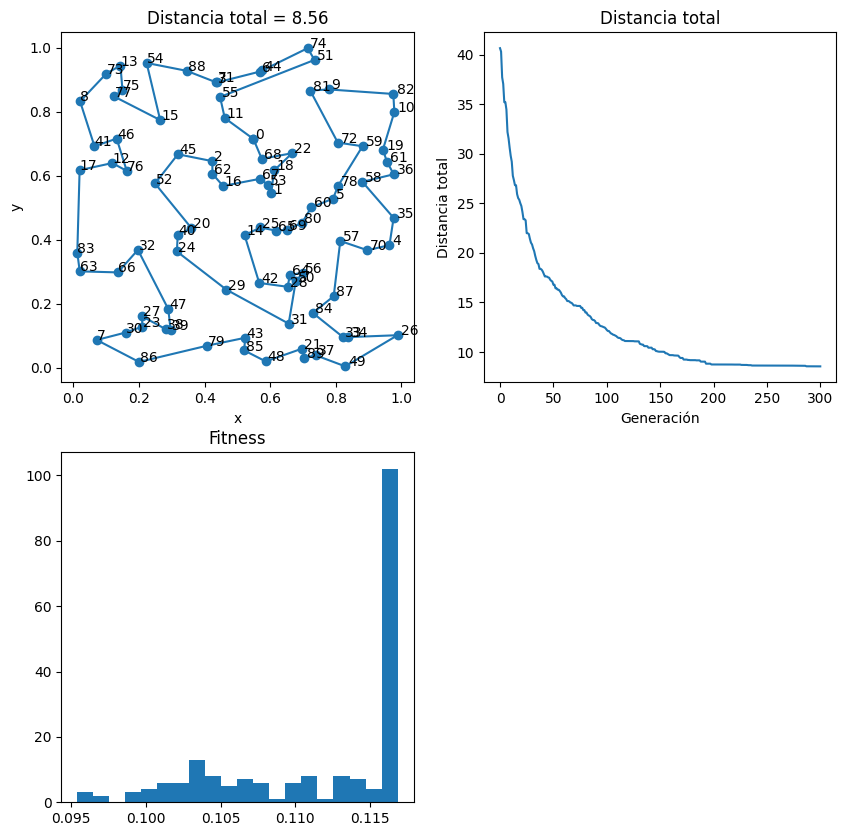

[ 0 11 55 51 74 44  6  3 71 88 54 15 77 75 13 73  8 41 46 76 12 17 83 63
 66 32 47 39 38 27 23 30  7 86 79 43 85 48 21 89 37 49 26 34 33 84 87 57
 70  4 35 58 36 61 19 10 82  9 81 72 59 78  5 60 80 69 65 25 14 42 28 64
 56 50 31 29 24 40 20 52 45  2 62 16 67 53  1 18 22 68  0]


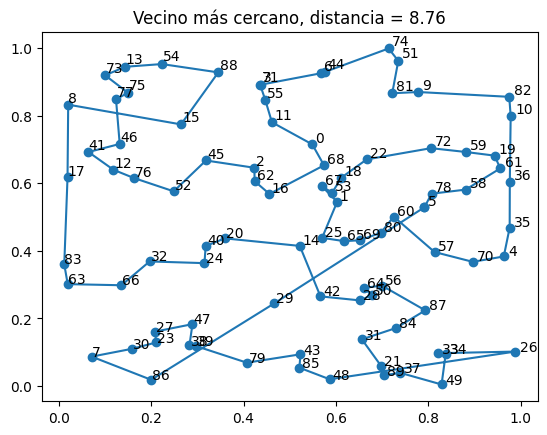

In [4]:
np.random.seed(0)
X = ciudades(90)

inicial = X
ge = GeneticAlgorithm(inicial, generations=300, mutationRate=0.5, poblationSize=200, elitism=True, elitePercentage=0.05, tournamentSize=10)
ge.run()
print(ge.route)

vmc = metodo_vecino_cercano(inicial)
Xv = vmc[1]
plt.plot(Xv[:,0], Xv[:,1], '-o')
for i in range(len(X)):
    plt.text(inicial[i,0]*1.01, inicial[i,1]*1.01, i)
plt.title(f'Vecino más cercano, distancia = {vmc[0]:.2f}')
plt.show()